# Nanopore linker analysis

In [3]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pysam
from functions_ import *
from plotting import *
from utils import *
import csv
from Nanopore_functions import *
from linker_analysis_functions import *
from Bio import SeqIO
from matplotlib import patches
import gzip 
from matplotlib.colors import LinearSegmentedColormap
import ast 
import json 

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    #"#2C3E5E",  
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
] , N=256)

custom_params = {"axes.spines.right": False, "axes.spines.top": False,'axes.linewidth':1}
sns.set_theme(context="paper",
              style='ticks',
              palette="Greys_r",rc=custom_params
             )
plt.rcParams['svg.fonttype'] = 'none'
lw = 1
lw = 1
fs = 7
hi = 10.5 *0.75 # 6.69291
wi3 = 2.24 # 7.08661
wi2 = 4.76
wi1 = 7.24
nr = 5

short_fn = np.vectorize(lambda x: x[:5])
#matplotlib.rcParams.update({'font.size': fs})
matplotlib.rcParams['axes.linewidth'] = 1
sns.set_context("paper", rc={"font.size":fs,
                             "axes.titlesize":fs+1,
                             "axes.labelsize":fs,
                             'axes.linewidth':1,    
                            "xtick.labelsize": fs,
                            "ytick.labelsize": fs,
                            "legend.fontsize": fs,
                            "legend.title_fontsize": fs+1}) 

In [4]:

ref_R2 = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaAtgtccgcgAaagcgcagaacgatccgctgctgccgggctatagctttaacgcAcatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgAgaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggccTctatagcgaactgctgAcAattaacctgctggaacagctgctgctgcgccgCATGGAAGCGATTAACGAAAGCagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcCTGCATCCGCCGATGGATAACCGcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagcccTagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggccTcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtGAACGATGTGGCGGTGAAACTGAGCGGGTAAggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper() ## R2

cut_site_seq_left= "gccacaa".upper()
cut_site_seq_right= "tgctgaaaac".upper()

wt_linker_left = "INESSGL" 
wt_linker_right = "IDEAAKGSHLPP"

Here, we first **analyze** the linkers variants and their cooccurrence (looped over all barcodes), inclduing some standard barplots of the variants. 

The likers will be **renamed** (see the linker_renaming.txt files), please check that the renaming was performed correctly, since some uncommon mutations my interfere with the renaming process.

In [106]:
for barcode in range(13,22):
    input_folder = f"/home/student/anna/DMS_analysis/data/Nanopore_P0115/barcode{barcode}/highly_accurate_basecalling/filtered_Q20_maxminlen/" ## please set the right file path


    FigFolder = f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/barcode{barcode}/"
    if not os.path.exists(FigFolder):
        os.makedirs(FigFolder)

    all_left_linkers, all_right_linkers = get_linker_regions(input_folder= input_folder+ "minimap2_alignment", ref = ref_R2, cut_site_seq_left=cut_site_seq_left, cut_site_seq_right= cut_site_seq_right, left_linker_region_len= 12*3, right_linker_region_len= 20*3)


######### left linker
    read_dir = "R1"
    left_linkers_counts, left_linker_list = get_linker_variants(linker_alignments=all_left_linkers,  wt_linker = wt_linker_left if read_dir=="R1" else wt_linker_right, read_dir = read_dir)

    # sort linkers by frequency
    linkers_sorted = {k: v for k, v in sorted(left_linkers_counts.items(), key=lambda item: item[1], reverse=True)}
    total_reads = sum(linkers_sorted.values())
    linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

    # exclude wt and linkers with less than 0.05% frequency
    linkers_sorted_perc.pop("wt")

    linkers_perc_filt, left_linker_renaming = rename_left_linkers(linkers_sorted_perc.keys(), linkers_sorted_perc)

    linkers_perc_filt = {k: v for k, v in linkers_perc_filt.items() if v > 0.1}


    ### plot linker variants
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values(), color ="#22577A")
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of reads")
    plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title(f"Linker variants for {barcode} {read_dir}")
    plt.savefig(f"{FigFolder}/linker_distribution_{read_dir}.pdf", bbox_inches="tight")
    plt.savefig(f"{FigFolder}/linker_distribution_{read_dir}.png", bbox_inches="tight")
    plt.close()

    linkers_perc_filt = pd.DataFrame.from_dict(linkers_perc_filt, orient="index")
    linkers_perc_filt.to_csv(f"{FigFolder}/linker_distribution_{read_dir}.csv")


######### right linker
    read_dir = "R2"
    right_linkers_counts, right_linkers_list = get_linker_variants(linker_alignments=all_right_linkers, wt_linker = wt_linker_left if read_dir=="R1" else wt_linker_right, read_dir = read_dir)

    # sort linkers by frequency
    linkers_sorted = {k: v for k, v in sorted(right_linkers_counts.items(), key=lambda item: item[1], reverse=True)}
    total_reads = sum(linkers_sorted.values())
    linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}
    # exclude wt and linkers with less than 0.05% frequency
    linkers_sorted_perc.pop("wt")
    linkers_perc_filt, right_linker_renaming = rename_right_linkers(linkers_sorted_perc.keys(), linkers_sorted_perc)
    
    linkers_perc_filt = {k: v for k, v in linkers_perc_filt.items() if v > 0.1}

    ### plot linker variants
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values(), color ="#22577A")
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of reads")
    plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title(f"Linker variants for {barcode} {read_dir}")
    plt.savefig(f"{FigFolder}/linker_distribution_{read_dir}.pdf", bbox_inches="tight")
    plt.savefig(f"{FigFolder}/linker_distribution_{read_dir}.png", bbox_inches="tight")
    plt.close()

    linkers_perc_filt = pd.DataFrame.from_dict(linkers_perc_filt, orient="index")
    linkers_perc_filt.to_csv(f"{FigFolder}/linker_distribution_{read_dir}.csv")


######## cooccurrence
    cooccurrences = []
    for idx, right_linker in enumerate(right_linkers_list): 
        if right_linker == "": 
            continue
        left_linker = left_linker_list[idx] 
        right_linker_renamed = right_linker_renaming[right_linker] if right_linker != "wt" else "wt"
        left_linker_renamed = left_linker_renaming[left_linker] if left_linker != "wt" else "wt"

        cooccurrences.append(f"{left_linker_renamed}_{right_linker_renamed}")
    
    with open(f"{FigFolder}/cooccurrences.txt", "w") as f: 
        f.write("\n".join(cooccurrences))
    
    with open(f"{FigFolder}/linker_renaming_left_linker.json", "w") as f:
        json.dump(left_linker_renaming, f, indent=4)
    
    with open(f"{FigFolder}/linker_renaming_right_linker.json", "w") as f:
        json.dump(right_linker_renaming, f, indent=4)
    
    if not os.path.exists(f"{input_folder}/processed_reads"):
        os.makedirs(f"{input_folder}/processed_reads")
        
    with open(f"{input_folder}/processed_reads/all_left_linkers.jso", "w") as f:
        json.dump(all_left_linkers, f, indent=4)
    
    with open(f"{input_folder}/processed_reads/all_right_linkers.json", "w") as f:
        json.dump(all_right_linkers, f, indent=4)
    
        
    print("Barcode", barcode, "done")   


Status: 1 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_70_1.bam
Status: 2 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_73_0.bam
Status: 3 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_17_0.bam
Status: 4 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_91_1.bam
Status: 5 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_25_0.bam
Status: 6 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_89_0.bam
Status: 7 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_90_1.bam
Status: 8 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_93_0.bam
Status: 9 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_66_0.bam
Status: 10 / 158 done
Processed fastq_runid_1375da9897689a251ba506449c1d303f48c780f1_21_1.bam
Status: 11 / 158 done
Processed fastq_runid_1375da9897689a251ba506449

### Linker evolution analysis

In [2]:
## load the (precviously generated, see above) data

all_left_linkers = pd.DataFrame(dtype = float)
all_right_linkers = pd.DataFrame(dtype = float)
all_linker_vars = []
barcodes =  [13, 14, 18, 20]#[13, 16, 19, 21]#[13, 14, 15,18, 20] #[13, 16, 17,19, 21]
barcodes = [str(bc) for bc in barcodes]
for barcode in barcodes: 
    FigFolder = f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/barcode{barcode}/"
    left_linkers = pd.read_csv(f"{FigFolder}/linker_distribution_R1.csv", index_col = 0).T
    left_linkers.index = [str(barcode)]
    all_left_linkers = pd.concat([all_left_linkers, left_linkers], axis = 0)

    right_linkers = pd.read_csv(f"{FigFolder}/linker_distribution_R2.csv", index_col = 0).T
    all_right_linkers = pd.concat([all_right_linkers, right_linkers], axis = 0)

all_right_linkers.index = [str(bc) for bc in barcodes]
all_left_linkers.index = [str(bc) for bc in barcodes]

all_right_linkers.fillna(0, inplace = True)
all_left_linkers.fillna(0, inplace = True)

all_right_linkers = all_right_linkers/100 #calcuate mutation rates from percentages
all_left_linkers = all_left_linkers/100

In [5]:
### heatmaps
## filter for the top n linkers with the highest variance over the different time steps 
n_linkers = 10 

left_vars = all_left_linkers.var()
left_quant = n_linkers/all_left_linkers.shape[1]
left_quantile_threshold = np.percentile(left_vars, 100-left_quant*100)
left_top_indices = [i for i, var in enumerate(left_vars) if var >= left_quantile_threshold]
left_top_vars = all_left_linkers.iloc[:,left_top_indices]



right_vars = all_right_linkers.var()
right_quant = n_linkers/all_right_linkers.shape[1]
right_quantile_threshold = np.percentile(right_vars, 100-right_quant*100)
right_top_indices = [i for i, var in enumerate(right_vars) if var >= right_quantile_threshold]
right_top_vars = all_right_linkers.iloc[:,right_top_indices]

# sort after enrichment of the final day
right_top_vars = right_top_vars.sort_values(right_top_vars.last_valid_index(), axis=1,ascending=False)
left_top_vars = left_top_vars.sort_values(left_top_vars.last_valid_index(), axis=1,ascending=False)

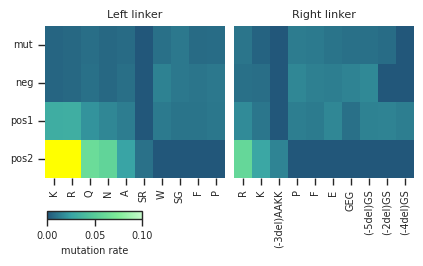

In [6]:
fig, ax = plt.subplots(1,2,figsize = (wi2, hi/4))
fig.subplots_adjust(wspace = 0.05)
my_cmap = custom_cmap#plt.get_cmap('viridis').copy()
my_cmap.set_over('Yellow')
sns.heatmap(left_top_vars, cmap = my_cmap, vmax = 0.10, ax = ax[0], cbar = False, yticklabels = True)
sns.heatmap(right_top_vars, cmap = my_cmap, vmax = 0.10, ax = ax[1], cbar = False, yticklabels = False)

ax[0].set_yticklabels(["mut", "neg", "pos1", "pos2"], rotation = 0)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90)
ax[0].set_title("Left linker")
ax[1].set_title("Right linker")
cbar_ax = fig.add_axes([0.13, -0.1, 0.2, 0.04])
cbar = fig.colorbar(ax[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate")
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/linker_evolution_heatmap{'_'.join(barcodes)}.png", bbox_inches = "tight")
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/linker_evolution_heatmap{'_'.join(barcodes)}.pdf", bbox_inches = "tight", dpi = 600)


In [ ]:
############# line plots

## filter df for linkers that have a overall occurrence of higher than 1 % 

all_right_linkers = all_right_linkers*100 #calcuate percentages
all_left_linkers = all_left_linkers*100

all_right_linkers = all_right_linkers.loc[:, all_right_linkers.max() > 1]
all_left_linkers = all_left_linkers.loc[:, all_left_linkers.max() > 1]

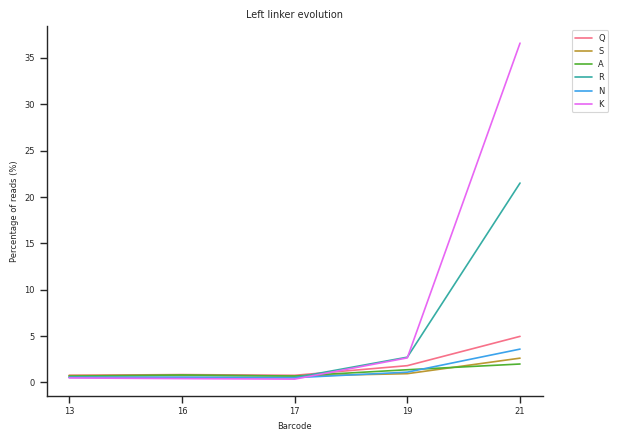

In [ ]:

# Number of distinct colors
colors = sns.color_palette("husl", all_left_linkers.shape[1]) 


for i in all_left_linkers.columns:
    plt.plot(all_left_linkers[i], label = i, color = colors[all_left_linkers.columns.get_loc(i)])

## put legend on right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Left linker evolution")
plt.xlabel("Barcode")
plt.ylabel("Percentage of reads (%)")
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/left_linker_evolution_barcodes{'_'.join(barcodes)}.png", bbox_inches = "tight")
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/left_linker_evolution_barcodes{'_'.join(barcodes)}.pdf", bbox_inches = "tight")
plt.show()

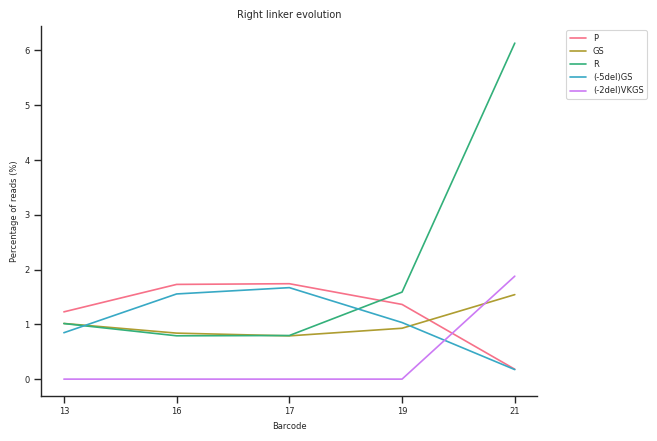

In [ ]:
colors = sns.color_palette("husl", all_right_linkers.shape[1]) 

for i in all_right_linkers.columns:
    plt.plot(all_right_linkers[i], label = i, color = colors[all_right_linkers.columns.get_loc(i)],)
plt.title("Right linker evolution")
## put legend on right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Barcode")
plt.ylabel("Percentage of reads (%)")
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/right_linker_evolution_barcodes{'_'.join(barcodes)}.png", bbox_inches = "tight")
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/right_linker_evolution_barcodes{'_'.join(barcodes)}.pdf", bbox_inches = "tight")
plt.show()

### Analyze coocurrence

In [7]:
all_cooccs = {}
all_linker_vars = []
barcodes =[13, 14, 15,18, 20]#  [13, 16, 17,19, 21]#[13, 14, 15,18, 20]
barcodes = [str(bc) for bc in barcodes]
for barcode in barcodes: 
    FigFolder = f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/barcode{barcode}/"
    with open(f"{FigFolder}/cooccurrences.txt", "r") as f:
        cooccurrences = f.read().split("\n")
    cooccs_counts = dict(Counter(cooccurrences))
    
    cooccs_perc = {k: v/sum(cooccs_counts.values())*100 for k, v in cooccs_counts.items()} 
    cooccs_perc_filt = {k: v for k, v in cooccs_perc.items() if v > 0.01}.copy() ## filter out variants with low percentage, likely noise

    # ## normalize filtered cooccs_perc
    cooccs_perc_filt_norm = {k: v/sum(cooccs_perc_filt.values())*100 for k, v in cooccs_perc_filt.items()}

    all_linker_vars = list(set(all_linker_vars+ list(cooccs_perc_filt_norm.keys())))

    all_cooccs[barcode] = cooccs_perc_filt_norm


all_cooccs_df = pd.DataFrame(index = [str(bc) for bc in barcodes], columns = all_linker_vars, data = 0.0)

for barcode in barcodes:
    for linker in all_linker_vars:
        all_cooccs_df.loc[str(barcode), linker] = all_cooccs[barcode].get(linker, 0)


    

In [14]:
variants = {"WT":0, "single mutant": 0, "double mutant": 0}
for key, val in all_cooccs["13"].items(): 
    if key == "wt_wt" or key == "wt_GS" or key == "SG_wt" or key == "SG_GS": 
        variants["WT"] += val

    elif "wt" in key or "GS" in key or "SG" in key: 
        variants["single mutant"] += val
        
    else: 
        variants["double mutant"] += val

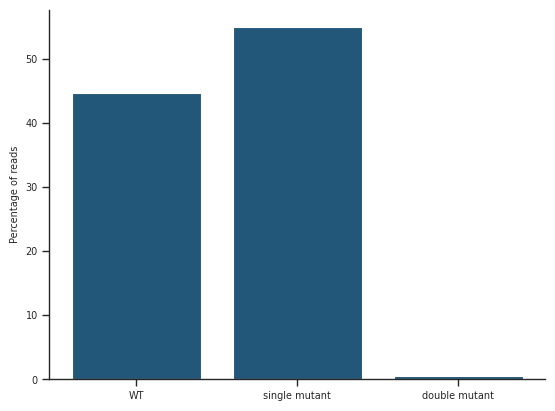

In [15]:
plt.bar(variants.keys(), variants.values(), color = "#22577A")
plt.ylabel("Percentage of reads")
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/WT_single_double_linker_mutants_after_mut_barplot.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/WT_single_double_linker_mutants_after_mut_barplot.pdf", bbox_inches = "tight", dpi = 600)

In [116]:
## sort by size 
all_cooccs["13"] = dict(sorted(all_cooccs["13"].items(), key=lambda item: item[1], reverse = True))
all_cooccs["13"].pop("wt_wt")

43.04053507376147

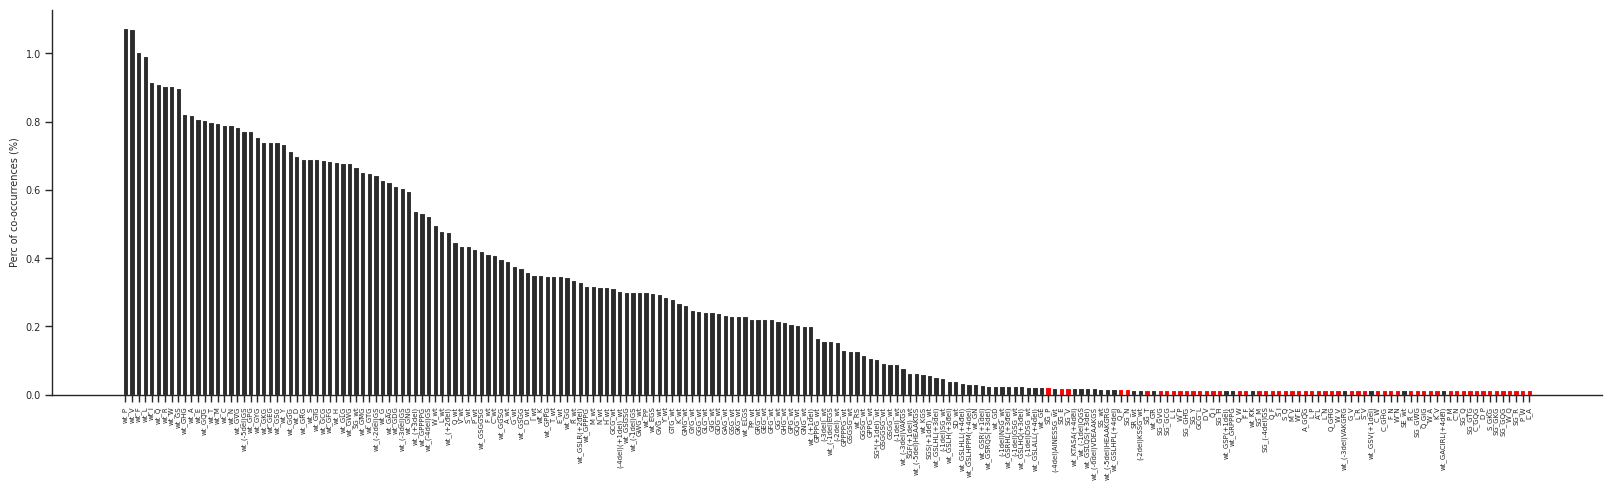

In [118]:
fig, axis = plt.subplots(1,1, figsize = (20, 5))
plt.bar(all_cooccs["13"].keys(), all_cooccs["13"].values())
plt.xticks(rotation=90, fontsize = 5)
##plot bars whose label does not include "wt" in red: 
for i, label in enumerate(all_cooccs["13"].keys()):
    if "wt" not in label:
        plt.bar(i, all_cooccs["13"][label], color = "red")
plt.ylabel("Perc of co-occurrences (%)")
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/cooccurrence_linkers_barcode13_perc.png", bbox_inches = "tight")
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/cooccurrence_linkers_barcode13_perc.pdf", bbox_inches = "tight")
plt.show()

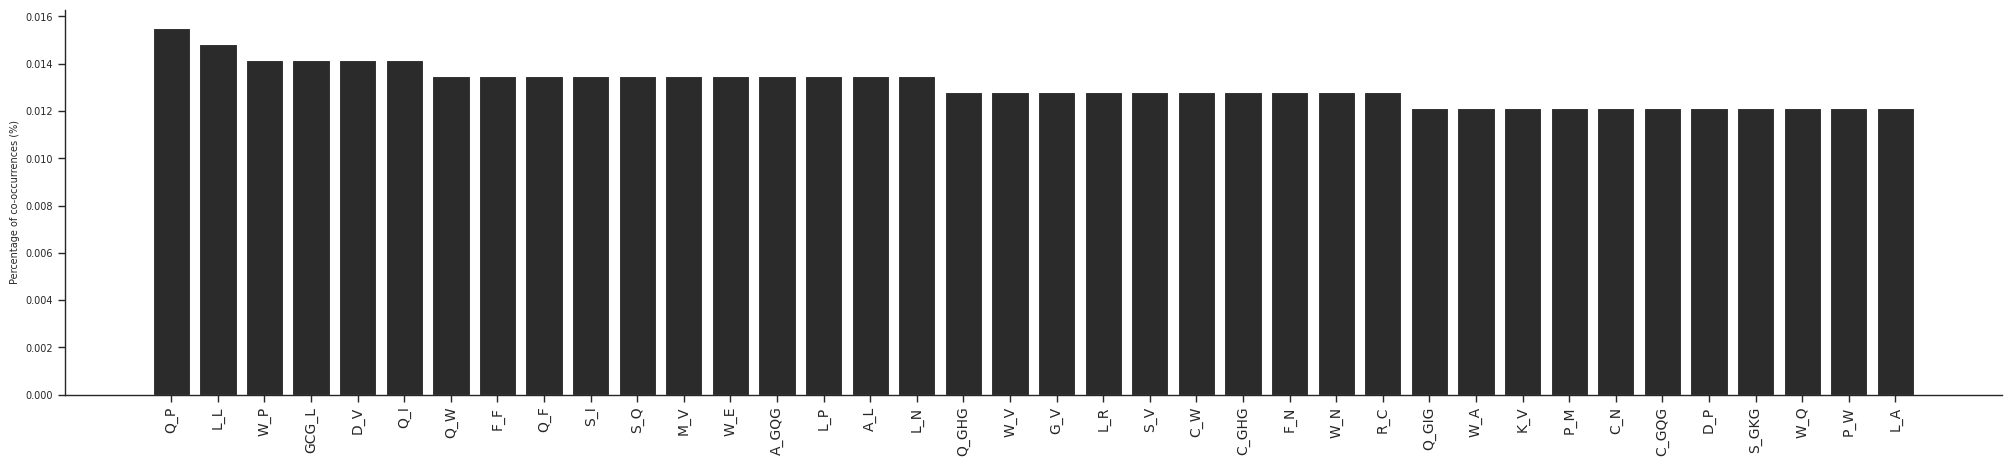

In [119]:
##filter out reads that have wt in the name 
all_cooccs["13"] = {k: v for k, v in all_cooccs["13"].items() if "wt" not in k and "SG" not in k and "GS" not in k}

fig, axis = plt.subplots(1,1, figsize = (25, 5))
plt.bar(all_cooccs["13"].keys(), all_cooccs["13"].values())
plt.xticks(rotation=90, fontsize = 10)
##plot bars whose label does not include "wt" in red: 
plt.ylabel("Percentage of co-occurrences (%)")
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/cooccurrence_linkers_barcode13_only_coocc_perc.png", bbox_inches = "tight")
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/cooccurrence_linkers_barcode13_only_coocc_perc.pdf", bbox_inches = "tight")
plt.show()

In [120]:
## filter df for linkers that have a overall occurrence of higher than 1.5 % 
all_cooccs_df = all_cooccs_df.loc[:, all_cooccs_df.max() > 1.5]

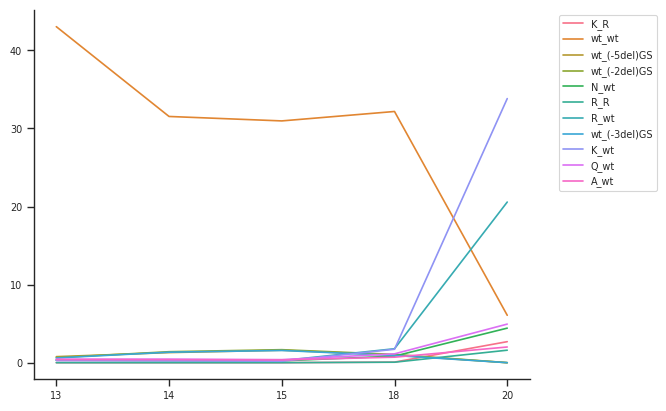

In [121]:
# Number of distinct colors
colors = sns.color_palette("husl", all_cooccs_df.shape[1]) 


for i in all_cooccs_df.columns:
    plt.plot(all_cooccs_df[i], label = i, color = colors[all_cooccs_df.columns.get_loc(i)])
## put legend on right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/cooccurrence_linkers_{'_'.join(barcodes)}.png", bbox_inches = "tight")
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/cooccurrence_linkers_{'_'.join(barcodes)}.pdf", bbox_inches = "tight")

plt.show()